In [366]:
import numpy as np
import scipy
from scipy import spatial

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import torch
import os
import time
from torch import nn
import numpy as np
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad
import torch.autograd as autograd

## Display results from pdedgan-PINN-final.py
The generator takes a  batch of samples from the one-D normal distribution and returns a batch of vectors in R^2.  The first component x' of each vector is an x value and the second compononent u' is the solution at that x value.

let
$$
 X \sim \mathcal{N}(\mu,\,\sigma^{2}) ~~~ with ~~ \mu=0 ~~~ and ~~~ \sigma=1
$$
then
$$
gen(X) ~=~ (x',~ u')
$$
The discriminator takes batches of triples from the true solution samples of the form
$$
( x, ~ u, ~\frac{d}{dx}(x \frac{du}{dx}) ~)
$$
The torch function Du(x,u) defined below is used to compute this second derivative operator from the generator (x', u') values.
So the generator is trying to fool the discriminator with
$$
dis(~ gen(X)[:,0], ~~gen(X)[:,1], ~~ Du(X,gen(X)[:,1]) ~)
$$

In [8]:
# defining generator class

class generator(nn.Module):    
    def __init__(self):      
        super(generator, self).__init__()
        self.l1 = nn.Linear(1,300)
        self.l2 = nn.Linear(300,1000)
        self.l3 = nn.Linear(1000,800)
        self.l4 = nn.Linear(800,2)
        self.rl = nn.Tanh()
        
    def forward(self, x):
        z = self.rl(self.l1(x))
        u = self.rl(self.l2(z))
        u = self.rl(self.l3(u))
        z = self.l4(u)
        return z

In [9]:
class discriminator(nn.Module):   
    def __init__(self):       
        super(discriminator, self).__init__()
        self.l1 = nn.Linear(3,300)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(300,300)
        self.l3 = nn.Linear(300,200)
        self.l4  = nn.Linear(200,1)
        self.sig = nn.Sigmoid()
        
    def forward(self, z):
        u = self.relu(self.l1(z))
        u = self.relu(self.l2(u))
        u = self.relu(self.l3(u))
        out = self.sig(self.l4(u))
        return out


In [10]:
vxn  = 1000
vx =np.linspace(0, np.pi, vxn) 
ix = torch.FloatTensor(vx).reshape(vxn,1)
#torch.rand(batch_size*1,1)

$$
\frac{d^2(x*u(x))}{dx^2} ~=~ \frac{dh}{dx}  ~~~where~ h ~=~ \frac{d}{dx}x*u(x)
$$

$$
\frac{d}{dx}x*u(x) ~=~ u(x) ~+~ x \frac{d (sin(2x)^2)}{dx} ~=~ u(x) ~+~ x*2*sin(2x)cos(2x)*2
$$

$$
\frac{dh}{dx} ~=~ \frac{d}{dx}(u(x) ~+~ 4x*sin(2x)cos(2x)) ~=~ 4*sin(2x)cos(2x)~+~4*sin(2x)cos(2x)~+~x*[ cos(2x)cos(2x)2 ~-~ sin(2x)sin(2x)2]
$$

$$
\frac{d^2(x*u(x))}{dx^2} ~=~ 8*sin(4x) ~+~ 2x*cos(4x)
$$

In [11]:
batch_size = 10
num_batches =20
LAMBDA = 0.1
import random

def u_true2(x):
    u = np.sin(2*x)**2
    return u/8.0

def u_true(x):
    u = np.sin(x)**2
    return u

def f_true2(x):
    f = np.sin(4.0*x)/4.0+x*np.cos(4*x)
    #f = 4.0*np.cos(2.0*x)
    return f
def f_true(x):
    f = np.sin(2.0*x)+2.0*x*np.cos(2*x)
    #f = 4.0*np.cos(2.0*x)
    return f
vxn  = 2000
vx =np.linspace(0, np.pi, vxn) 
ix = torch.FloatTensor(vx).reshape(vxn,1)

import random
btches = []
ubtches = []
fakebtches = []
real_data_batches = []
for i in range(num_batches):
    b = random.choices(vx,k=batch_size)
    bar = np.array(b)
    ub = u_true(bar)
    fb = f_true(bar)
    ub0 = torch.FloatTensor(ub).reshape(batch_size,1)
    ub0.requires_grad=True
    ib = torch.FloatTensor(b).reshape(batch_size,1)
    ifb = torch.FloatTensor(fb).reshape(batch_size,1)
    ib.requires_grad=True
    ifb.requires_grad = True
    real_data_batches.append(torch.cat((ib, ub0, ifb),1))
    btches.append(ib)
    ubtches.append(ub0)
    noise = torch.randn(batch_size*1,1)
    fake = torch.FloatTensor(noise).reshape(batch_size,1)
    fake.requires_grad=True
    fakebtches.append(fake)
print(fakebtches[0].shape)
print(real_data_batches[0].shape)

torch.Size([10, 1])
torch.Size([10, 3])


In [12]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

def Du(x,u):
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0] #nth_derivative(flat(u), wrt=x, n=1)
    xv =x[:,0].reshape(batch_size,1)
    z = u_x*xv
    u_xx = grad(flat(z), x, create_graph=True, allow_unused=True)[0] #nth_derivative(flat(u), wrt=x, n=1)
    f = u_xx
    return f



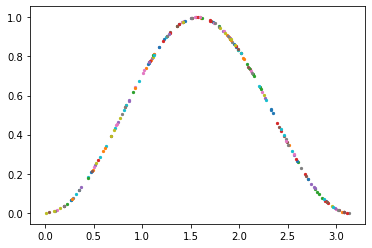

In [13]:
for i in range(num_batches):
    x = btches[i].detach().numpy()
    y = ubtches[i].detach().numpy()
    yy = fakebtches[i].detach().numpy()
    plt.scatter(x,y, s=5)
    #plt.scatter(x,yy)

In [14]:
gen =  generator()
gen.load_state_dict(torch.load('generator-tanh-pinn-final'))

<All keys matched successfully>

points out of range: 0


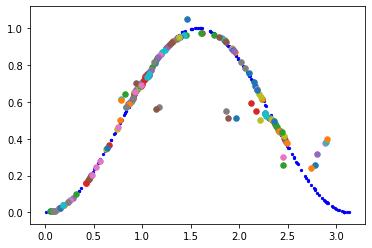

In [16]:
numdots = 0
for i in range(0, num_batches):
    x = btches[i].detach().numpy()
    y = ubtches[i].detach().numpy()
    plt.scatter(x,y, color='b', s = 5)
for i in range(0,num_batches):
    fakes = fakebtches[i]
    noise = torch.randn(batch_size, 1)
    noisev = autograd.Variable(noise)  # totally freeze netG
    fout = gen(noisev)
    z = fout.detach().numpy()
    #numdots = 0
    for j in range(int(batch_size)):
        zx = z[j,0]
        zy = z[j,1]
        if zy < 1.2 and zy > -0.1:
            plt.scatter(zx, zy, s=30)
        else:
            numdots+=1
        #print(zx, noisev[j].detach().numpy())
print("points out of range:", numdots)

notice above that we are still not geting the solution correctly resolve beyond x=2.5

points out of range on x asis = 0


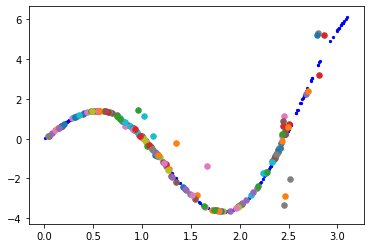

In [543]:
numpts = 0
for i in range(0,num_batches):
    x = btches[i].detach().numpy()
    y = f_true(x)
    #y = ubtches[i].detach().numpy()
    plt.scatter(x,y, color='b', s = 5)
for i in range(0,num_batches):
    noise = torch.randn(batch_size, 1)
    noisev = autograd.Variable(noise)
    noisev.requires_grad = True
    fout = gen(noisev)
    x = fout[:,0]
    u = fout[:,1]
    #print(Du(x,u))
    for j in range(batch_size):
        x = noisev
        u = fout[j,1].reshape(1,1)
        
        #print(Du(x,u)[j])
        xv = fout[j,0].detach().numpy()
        f =  Du(x,u)[j].detach().numpy()
        #print(f)
        if xv < 3.2:
            plt.scatter(xv,f, s=30)
        else:
            numpts += 1
print('points out of range on x asis =', numpts)

again the fit above 2.5 is spotty at best, but the rest is not too bad.

In [542]:
import random
btches = []
ubtches = []
fakebtches = []
real_data_batches = []
for i in range(num_batches):
    b = random.choices(vx,k=batch_size)
    bar = np.array(b)
    ub = u_true2(bar)
    fb = f_true2(bar)
    ub0 = torch.FloatTensor(ub).reshape(batch_size,1)
    ub0.requires_grad=True
    ib = torch.FloatTensor(b).reshape(batch_size,1)
    ifb = torch.FloatTensor(fb).reshape(batch_size,1)
    ib.requires_grad=True
    ifb.requires_grad = True
    real_data_batches.append(torch.cat((ib, ub0, ifb),1))
    btches.append(ib)
    ubtches.append(ub0)
    noise = torch.randn(batch_size*1,1)
    fake = torch.FloatTensor(noise).reshape(batch_size,1)
    fake.requires_grad=True
    fakebtches.append(fake)
print(fakebtches[0].shape)
print(real_data_batches[0].shape)

torch.Size([10, 1])
torch.Size([10, 3])


now we show the solution if we ignore the differential equation

In [529]:
gen =  generator()
gen.load_state_dict(torch.load('generator-tanh-best-no-Du'))

<All keys matched successfully>

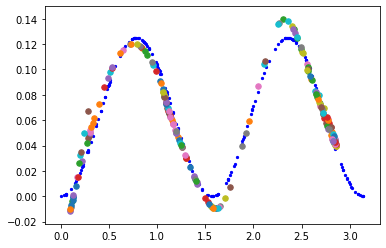

In [530]:
numdots = 0
for i in range(0, num_batches):
    x = btches[i].detach().numpy()
    y = ubtches[i].detach().numpy()
    plt.scatter(x,y, color='b', s = 5)
for i in range(0,num_batches):
    fakes = fakebtches[i]
    noise = torch.randn(batch_size, 1)
    noisev = autograd.Variable(noise)  # totally freeze netG
    fout = gen(noisev)
    z = fout.detach().numpy()
    #numdots = 0
    for j in range(int(batch_size)):
        zx = z[j,0]
        zy = z[j,1]
        if zy < 1.2 and zy > -0.1:
            plt.scatter(zx, zy, s=30)
        else:
            numdots+=1
        #print(numdots, zx, zy)

points out of range on x asis = 0


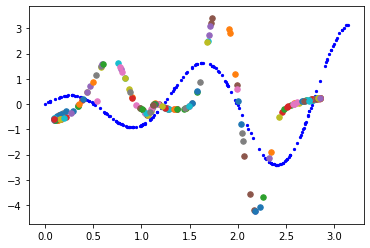

In [532]:
numpts = 0
for i in range(0,num_batches):
    x = btches[i].detach().numpy()
    y = f_true2(x)
    #y = ubtches[i].detach().numpy()
    plt.scatter(x,y, color='b', s = 5)
for i in range(0,num_batches):
    noise = torch.randn(batch_size, 1)
    noisev = autograd.Variable(noise)
    noisev.requires_grad = True
    fout = gen(noisev)
    x = fout[:,0]
    u = fout[:,1]
    #print(Du(x,u))
    for j in range(batch_size):
        x = noisev
        u = fout[j,1].reshape(1,1)
        
        #print(Du(x,u)[j])
        xv = fout[j,0].detach().numpy()
        f =  Du(x,u)[j].detach().numpy()
        #print(f)
        if xv < 3.2:
            plt.scatter(xv,f, s=30)
        else:
            numpts += 1
print('points out of range on x asis =', numpts)

this is using u = sin(2x)**2/8 
the fit to the differential equation is not very good.